In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Importing essential Libraries
import os
import tensorflow.keras as k
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import ResNet50,InceptionResNetV2,VGG16,ResNet101,ResNet101V2, InceptionV3,MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.models import load_model
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.preprocessing import image
from tensorflow.keras import layers,models

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/last.csv')

In [ ]:
#Creating Data Generators
datagen = ImageDataGenerator(rescale=1/255 ,
        validation_split=0.1,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest') 

In [ ]:
#Spliting Data into train and validation
train_generator = datagen.flow_from_dataframe(
        dataframe=data,
        directory="/content/drive/MyDrive/new",
        x_col="data",
        y_col="label",
        shuffle=True,
        batch_size=8,
        color_mode="rgb",
        class_mode="categorical", 
        target_size=(224,224))



Found 2636 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 52 invalid image filename(s) in x_col="data". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
#Defining the model to be used for training

base_model = MobileNet(weights='imagenet',input_shape=(331,331,3),include_top=False,pooling='avg')

for layer in base_model.layers[:-4]:
    layer.trainable = False

model = Sequential([
  base_model,
  Dense(2048, activation='relu'),
  Dropout(0.5),
  Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(3, activation="softmax")
])

17227776/17225924 [==============================] - 0s 0us/step


close    1072
yawn     1053
open      563
Name: label, dtype: int64
Sum : 2688


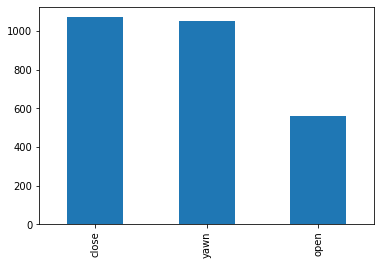

In [ ]:
#Data distribution plot
datafr = pd.read_csv('/content/drive/MyDrive/last.csv')
datafr['label'].value_counts().plot(kind = 'bar')
print(datafr['label'].value_counts())
print("Sum :", datafr['label'].value_counts().sum())

In [ ]:
#Compiling the model
optimizer = Adam(learning_rate = 0.00005, beta_1 = 0.88)
model.compile(
    optimizer=optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

train_steps = np.ceil(train_generator.n/train_generator.batch_size)

In [ ]:
#Calculating weights for the classes
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
y_train = datafr['label']
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)))

In [ ]:
class_weights

{0: 0.835820895522388, 1: 1.5914742451154529, 2: 0.8509021842355176}

In [ ]:
#Training the model

history = model.fit(
    train_generator,
    epochs=10 ,
    batch_size=256,
    class_weight=class_weights,
    steps_per_epoch=train_steps)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
330/330 [==============================] - 857s 2s/step - loss: 0.4281 - accuracy: 0.8300
Epoch 2/10
330/330 [==============================] - 71s 216ms/step - loss: 0.2086 - accuracy: 0.9237
Epoch 3/10
330/330 [==============================] - 70s 211ms/step - loss: 0.1877 - accuracy: 0.9378
Epoch 4/10
330/330 [==============================] - 69s 210ms/step - loss: 0.1387 - accuracy: 0.9503
Epoch 5/10
330/330 [==============================] - 68s 207ms/step - loss: 0.1078 - accuracy: 0.9640
Epoch 6/10
330/330 [==============================] - 68s 206ms/step - loss: 0.1062 - accuracy: 0.9636
Epoch 7/10
330/330 [==============================] - 68s 206ms/step - loss: 0.0836 - accuracy: 0.9697
Epoch 8/10
330/330 [==============================] - 69s 208ms/step - loss: 0.0728 - accuracy: 0.9753
Epoch 9/10
330/330 [====================

dict_keys(['loss', 'accuracy'])


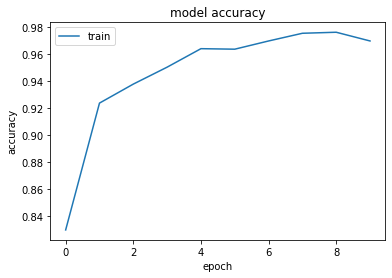

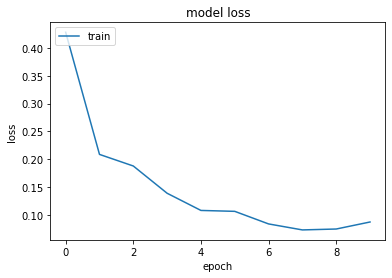

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Plot
import matplotlib.pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.savefig("/content/sample_data/acc_plot.jpg")
# "Loss"
plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.savefig("/content/sample_data/loss_plot.jpg")

In [ ]:
model.save("/content/drive/MyDrive/drowsines_eis_2021.h5");

In [ ]:
labels = (train_generator.class_indices)
labels

{'close': 0, 'open': 1, 'yawn': 2}

In [ ]:
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'close', 1: 'open', 2: 'yawn'}

In [ ]:
#Testing the model on the test dataset and preparing the required csv file

name=[]
y_pred=[]
confidence = []
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
s=0
Siz = (331,331,3)
for i in os.listdir('/content/drive/MyDrive/test/'):
    name.append(i)
    i = '/content/drive/MyDrive/test/' + i
    img=image.load_img(i,target_size=(331,331,3))
    img=image.img_to_array(img)/255
    pred=model.predict(img.reshape(1,331,331,3))
    x = np.argmax(pred[0])
    y_pred.append(labels[x])
    confidence.append([pred[0][x],x])
    s+=1
    if s%500==0:
        print(s)
    
output=pd.DataFrame((zip(name,y_pred)),columns=['data','label'])

In [ ]:
path = "/content/drive/MyDrive/new/"
name=[]
y_pred=[]
confidence = []

for i in range (5):
    pathim = path + datafr.data[i]
    img=image.load_img(pathim,target_size=(331,331,3))
    img=image.img_to_array(img)/255
    pred=model.predict(img.reshape(1,331,331,3))
    x = np.argmax(pred[0])
    y_pred.append(labels[x])
    confidence.append([pred[0][x],x])
print(pred)


[[0.0072147  0.04787509 0.9449102 ]]


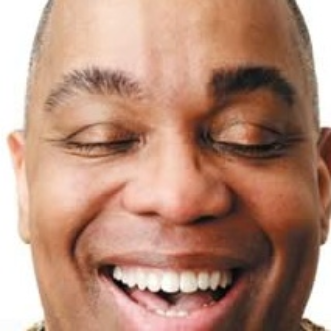

Class Predicted: close 
Class:  close 
Confidence:  0.9999957


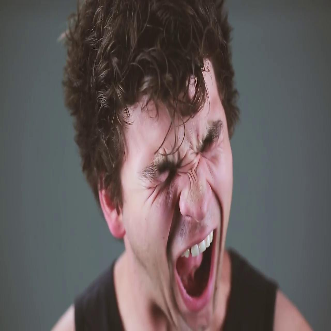

Class Predicted: yawn 
Class:  yawn 
Confidence:  0.9055092


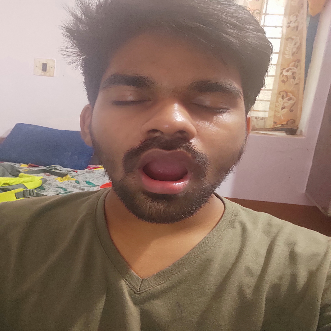

Class Predicted: yawn 
Class:  yawn 
Confidence:  0.99764806


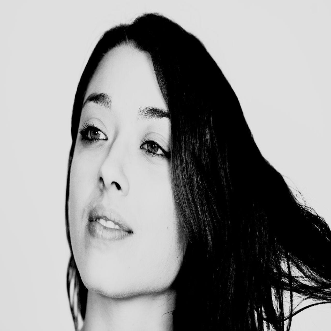

Class Predicted: open 
Class:  open 
Confidence:  0.9958379


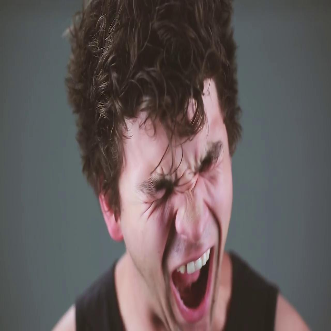

Class Predicted: yawn 
Class:  yawn 
Confidence:  0.9449102


In [ ]:
from google.colab.patches import cv2_imshow
import cv2

for i in range (5):
    pathim = path + datafr.data[i]
    img = cv2.imread(pathim)
    img = cv2.resize(img,(331,331))
    cv2_imshow(img)
    print("Class Predicted:",y_pred[i],"\nClass: ", datafr.label[i], "\nConfidence: ", confidence[i][0])

In [ ]:
from keras.models import load_model
import cv2
import numpy as np

In [ ]:
model = load_model('/content/drive/MyDrive/drowsines_eis_2021.h5')

In [ ]:
from google.colab.patches import cv2_imshow

2
yawning


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


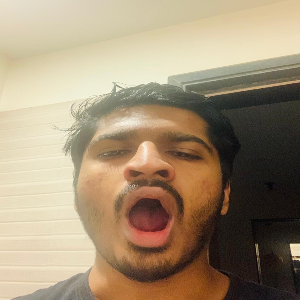

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (331, 331, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/sample_data/aditya.jpeg')
predict = model.predict_classes(image)
print(predict[0])
if predict[0] == 0:
  print('closed eyes')
elif predict[0] == 1:
  print('open eyes')
else:
  print('yawning')

img = cv2.imread('/content/sample_data/aditya.jpeg')
bigger = cv2.resize(img, (300, 300))
cv2_imshow(bigger)

In [ ]:
if prediction[0] == 0:
  print('closed eyes')
elif prediction[0] == 1:
  print('open eyes')
else:
  print('yawning')

yawning


In [ ]:
import keras
model = keras.models.load_model("/content/drive/MyDrive/drowsines_eis_2021.h5");

In [ ]:
import keras
model = keras.models.load_model("/content/sample_data/EIS_MOBILENETV3.h5");

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()



# Save the model.
with open('/content/sample_data/EIS_MOBV3.tfflite', 'wb') as f:
  f.write(tflite_quant_model)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmplhrbr24g/assets


In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()



# Save the model.
with open('/content/drive/MyDrive/model1.tflite', 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpgf9grucx/assets


INFO:tensorflow:Assets written to: /tmp/tmpgf9grucx/assets


In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()



# Save the model.
with open('/content/drive/MyDrive/modelfloat16_drowsiness.tflite', 'wb') as f:
  f.write(tflite_quant_model)


INFO:tensorflow:Assets written to: /tmp/tmpqomsqags/assets


INFO:tensorflow:Assets written to: /tmp/tmpqomsqags/assets


In [ ]:
#Import Numpy, Keras Image and MobileNetV3 libraries
import numpy as np
from keras.preprocessing import image


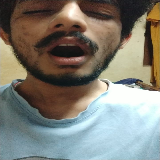

In [ ]:
#Load peacock jpeg image from local and set target size to 224 x 224
img = image.load_img('/content/sample_data/ram.jpeg', target_size=(160,160))
img